# Settings

## Imports

In [1]:
import sys,tweepy,csv,re, requests, json
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import os, time, re
import plotly.express as px

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import string
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gustavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Configs

In [3]:
import warnings

# Suppressing the warnings
warnings.filterwarnings('ignore') 

#Changing dir
folder = 'ML'
try:
    os.chdir(f'{os.getcwd()}/{folder}')
except:
    dir = os.getcwd().replace(os.getcwd().split('/')[-1], folder)
    os.chdir(dir)

# Getting Twitter

## API

In [4]:
#token
config = dotenv_values(".env")
bearer_token = config['BEARER_TOKEN']

#connections
auth = tweepy.OAuth2BearerHandler({bearer_token})
api = tweepy.API(auth)




def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    #print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

def get_tweet_v1(query, max_n):
    search_url = 'https://api.twitter.com/2/tweets/search/recent'
    tweets_dt = pd.DataFrame()

    print(f'Getting tweets...')

    try:
        # Querying the API
        json_response = connect_to_endpoint(search_url, query)
        
        try:
            tweets_dt = pd.DataFrame.from_dict(json_response['data'])
            
            try:
                n_token = json_response['meta']["next_token"]
                n = 0
                while n_token != 0 | n < max_n:
                    print(f'Next Token: {n} \n {n_token}')
                    query_next = query
                    query_next['next_token'] = n_token
                    json_response = connect_to_endpoint(search_url, query_next)
                    tweets_n = pd.DataFrame.from_dict(json_response['data'])
                    tweets_dt = pd.concat([tweets_dt,tweets_n], ignore_index=True)

                    n += 1
                    n_token = json_response['meta']["next_token"]
                
            except:
                print('Error to get next page')
        
        except:
            print('Error to get data from Json File')     

    except:
        print('Error to querying API')
        
    return tweets_dt


## Countries

Getting up to 1000 tweets each country

In [5]:
countries = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Denmark', 'Finland', 'France', 'Germany', 'Hungary',
        'Ireland', 'Italy', 'Latvia', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain','Sweden', 'Europe', 'UK']

filename = 'tweets_agri_2k.bz2'

if os.path.exists(filename) == False: 
    for c in countries:

        q = {
        'query': f'agriculture {c} -is:retweet',
        'max_results': 100,
        'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
        'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
        'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
        }

        t = get_tweet_v1(q, 10)
        t['country'] = c
        if c == countries[0]:
            tweets = t
        else:
            tweets = pd.concat([tweets, t], ignore_index=True)

    tweets.to_csv(filename, index=False,compression='bz2')
    print(f'File with {len(tweets)} saved.')

else:
    create_dt = time.strftime("%d/%m/%Y %H:%M:%S",time.strptime(time.ctime(os.path.getmtime(filename))))
    print(f'Reading {filename}, created at {create_dt}')
    tweets = pd.read_csv(filename)
    print(f'File with {len(tweets)} Tweets')
    

tweets.sample()

Reading tweets_agri_2k.bz2, created at 06/01/2023 01:49:21
File with 2126 Tweets


public_metrics      conversation_id  \
342  {'retweet_count': 0, 'reply_count': 1, 'like_c...  1608848617892384768   

                                                  text reply_settings lang  \
342  @Oludeewon Postdoc, Agriculture, Plant protect...       everyone   ca   

               author_id   edit_history_tweet_ids                created_at  \
342  1109779265543905282  ['1609118920165687297']  2022-12-31T09:27:01.000Z   

               id  in_reply_to_user_id  \
342  1.609119e+18          621103995.0   

                                     referenced_tweets  country  geo  
342  [{'type': 'replied_to', 'id': '160884861789238...  Germany  NaN

# Clean Your Text Data

## Worlds extractions

In [6]:
def clean_tweet(x, link, keyword, usernames):
    list_of_lists =[]
    if link == True:
        list_of_links = []
        words = x.split(' ')
        for word in words:
            if re.search('http', word):
                list_of_links.append(re.split("\W+",word.lower()))
        if len(list_of_links) > 0:
            list_of_lists.append(list_of_links[0])
    
    if keyword == True:
        list_of_keywords = []
        words = x.split()
        for word in words:
            if word.startswith('#'):
                list_of_keywords.append(word)
        if len(list_of_keywords) > 0:
            list_of_lists.append(list_of_keywords)
            
    if usernames == True:
        list_of_usernames = []
        words = x.split()
        for word in words:
            if word.startswith('@'):
                list_of_usernames.append(word.lower().replace('@',''))
        if len(list_of_usernames) > 0:
            list_of_lists.append(list_of_usernames)
    
    return  [item for sublist in list_of_lists for item in sublist]

        
# keyword extraction from tweets
def get_keywords(x):
    list_of_keywords = []
    words = x.split()
    for word in words:
        if word.startswith('#'):
            list_of_keywords.append(word)
    return list_of_keywords


In [7]:
tweets = tweets[tweets.lang == 'en']
tweets = tweets.reset_index(drop = True)

In [8]:
list_of_lists = tweets['text'].apply(lambda tweet : clean_tweet(tweet, link = True, keyword = False, usernames = True))
rem_list = [item for sublist in list_of_lists for item in sublist]

tweets['text_c'] = tweets['text'].apply( lambda tweet : ' '.join([word for word in re.split("\W+",tweet) if word.lower() not in rem_list]))

In [9]:
tweets['keywords'] = tweets['text'].apply( lambda tweet : get_keywords(tweet) )

In [10]:
tweets.sample(2)

public_metrics      conversation_id  \
1058  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1605970006793142276   
432   {'retweet_count': 0, 'reply_count': 2, 'like_c...  1607220396973256705   

                                                   text reply_settings lang  \
1058  @john4brexit You regular reminder that Minford...       everyone   en   
432   @Shoudlaz @Psygrav @FHHuntress Moors, European...       everyone   en   

               author_id   edit_history_tweet_ids                created_at  \
1058  987358254249529344  ['1606281712593272832']  2022-12-23T13:32:58.000Z   
432           4415375052  ['1608784565006655489']  2022-12-30T11:18:24.000Z   

                id  in_reply_to_user_id  \
1058           NaN         7.148543e+17   
432   1.608785e+18         9.797527e+08   

                                      referenced_tweets country  geo  \
1058  [{'type': 'replied_to', 'id': '160597000679314...      UK  NaN   
432   [{'type': 'replied_to', 'id': '160869768094298...  Europe  NaN   

                                                 text_c keywords  
1058  You regular reminder that Minford thinks we sh...       []  
432   Moors Europeans of African descent brought kno...       []

In [11]:
n =45
print('OLD: ', tweets['text'][n], '\n')
print('NEW: ', tweets['text_c'][n])

OLD:  @EU_Commission @EUInterpreters Cpec rpec projects 🌊💦 electric gas dam sugar steel mill cloth machines agriculture machines hospital machines plane train car bus made machines workshop made companies cheap rupees half rupees 🎁🎁 gift 🎁 china japan korea german Honduras Astonia Salvador France 

NEW:  Cpec rpec projects electric gas dam sugar steel mill cloth machines machines hospital machines plane train car bus made machines workshop made companies cheap rupees half rupees gift china japan korea german Honduras Astonia Salvador France


In [12]:
len(tweets)

1409

## PorterStemmer

In [13]:
# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

In [14]:
def stemming(df, text_col, name_new_col):
    # Store the column of the dataframe named as "text"
    X = df[text_col]
    cleaned_data=[]
    # For loop from first value to length(X), ^a-zA-Z means include small and capital case letters
    for i in range(len(X)):
        text = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
        text = text.lower().split()
        text = [stemmer.stem(word) for word in text if (word not in stop_words) and (word not in punct)]
        text = ' '.join(text)
        df.loc[ i ,name_new_col] = text
    print('Stemmer done!')

In [15]:
stemming(tweets, 'text_c', 'text_ps')

Stemmer done!


In [16]:
n =0
print('ORIGINAL: ', tweets['text'][n], '\n')
print('CLEAN: ', tweets['text_c'][n], '\n')
print('STEMMER: ', tweets['text_ps'][n])

ORIGINAL:  Academic spam is great! I've been invited to be a keynote speaker at a Plant Biology conference in Vienna 😂
95% sure it's spam, but tempted to say yes! Imagine it's legit and I find myself in Austria, speaking to a room of stunned plant experts about WWII Scottish agriculture... 

CLEAN:  Academic spam is great I ve been invited to be a keynote speaker at a Plant Biology conference in Vienna 95 sure it s spam but tempted to say yes Imagine it s legit I myself in Austria speaking to a room of stunned plant experts about WWII Scottish 

STEMMER:  academ spam great invit keynot speaker plant biolog confer vienna sure spam tempt say ye imagin legit austria speak room stun plant expert wwii scottish


## Sentiment Analyzes

TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. [link](https://textblob.readthedocs.io/en/dev/index.html)

In [17]:
tweets.sample(2)

public_metrics      conversation_id  \
469   {'retweet_count': 1, 'reply_count': 0, 'like_c...  1611014766520111108   
1058  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1605970006793142276   

                                                   text reply_settings lang  \
469   Rising fertiliser and energy prices will impac...       everyone   en   
1058  @john4brexit You regular reminder that Minford...       everyone   en   

               author_id   edit_history_tweet_ids                created_at  \
469   881799949834493952  ['1611014766520111108']  2023-01-05T15:00:26.000Z   
1058  987358254249529344  ['1606281712593272832']  2022-12-23T13:32:58.000Z   

                id  in_reply_to_user_id  \
469   1.611015e+18                  NaN   
1058           NaN         7.148543e+17   

                                      referenced_tweets country  geo  \
469                                                 NaN      UK  NaN   
1058  [{'type': 'replied_to', 'id': '160597000679314...      UK  NaN   

                                                 text_c keywords  \
469   Rising fertiliser energy will impact on costs ...       []   
1058  You regular reminder that Minford thinks we sh...       []   

                                                text_ps  
469   rise fertilis energi impact cost could lead un...  
1058  regular remind minford think mostli elimin man...

In [18]:
for i in tweets.index:
    text = tweets.loc[i,'text_ps']
    tweets.loc[i, 'TextBlob'] = TextBlob(text).sentiment.polarity
    #print(TextBlob(text).sentiment.polarity)
    tweets.loc[i, 'Vader'] = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    #print(SentimentIntensityAnalyzer().polarity_scores(text)['compound'], '\n')
    
tweets.sample(2)

public_metrics      conversation_id  \
820  {'retweet_count': 0, 'reply_count': 1, 'like_c...  1605511456421646337   
701  {'retweet_count': 0, 'reply_count': 2, 'like_c...  1608487356323233793   

                                                  text reply_settings lang  \
820  @SquishSquish8 The mediterranean sea - build a...       everyone   en   
701  @IIIperman @YBC_Ninja @SBakerMD The animal agr...       everyone   en   

               author_id   edit_history_tweet_ids                created_at  \
820  1153947733100814336  ['1605592966009040897']  2022-12-21T15:56:08.000Z   
701  1478840188914778113  ['1609235168241528833']  2022-12-31T17:08:56.000Z   

               id  in_reply_to_user_id  \
820           NaN         1.203842e+18   
701  1.609235e+18         1.519415e+18   

                                     referenced_tweets country  geo  \
820  [{'type': 'replied_to', 'id': '160557013796837...  Europe  NaN   
701  [{'type': 'replied_to', 'id': '160916056383725...      UK  NaN   

                                                text_c keywords  \
820  mediterranean sea build a giant dam across Str...       []   
701  animal is far worse in US is still beyond acce...       []   

                                               text_ps  TextBlob   Vader  
820  mediterranean sea build giant dam across strai...  0.026515 -0.2960  
701               anim far wors us still beyond accept  0.100000  0.3818

In [19]:
for i in tweets.index:
    text = tweets.loc[i,'text_c']
    tweets.loc[i, 'TextBlob_c'] = TextBlob(text).sentiment.polarity
    #print(TextBlob(text).sentiment.polarity)
    tweets.loc[i, 'Vader_c'] = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    #print(SentimentIntensityAnalyzer().polarity_scores(text)['compound'], '\n')
    
for i in tweets.index:
    text = tweets.loc[i,'text']
    tweets.loc[i, 'TextBlob_o'] = TextBlob(text).sentiment.polarity
    #print(TextBlob(text).sentiment.polarity)
    tweets.loc[i, 'Vader_o'] = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    #print(SentimentIntensityAnalyzer().polarity_scores(text)['compound'], '\n')
    
tweets.sample(2)

public_metrics      conversation_id  \
274   {'retweet_count': 0, 'reply_count': 0, 'like_c...  1610555365355044864   
1348  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1604414012166488070   

                                                   text reply_settings lang  \
274   Oddly enough, the arable land price in Romania...       everyone   en   
1348  @juliasm18659356 @_HenryBolton I don’t know, w...       everyone   en   

                author_id   edit_history_tweet_ids                created_at  \
274   1449643259458899970  ['1610555365355044864']  2023-01-04T08:34:56.000Z   
1348  1113778687931973633  ['1604490602015444992']  2022-12-18T14:55:44.000Z   

                id  in_reply_to_user_id  ...  geo  \
274   1.610555e+18                  NaN  ...  NaN   
1348           NaN         1.354551e+18  ...  NaN   

                                                 text_c keywords  \
274   Oddly arable land price in Romania is about sa...       []   
1348  I don know where British workers all those mig...       []   

                                                text_ps  TextBlob   Vader  \
274   oddli arabl land price romania finland somehow...  0.007708  0.1531   
1348  know british worker migrant previous protect e... -0.083333  0.1779   

      TextBlob_c  Vader_c  TextBlob_o  Vader_o  
274     0.086369  -0.5472    0.107202  -0.5472  
1348   -0.055556   0.2500   -0.055556   0.2500  

[2 rows x 22 columns]

In [20]:
def get_polarity(df, col):

    polarity = 0
    neutral = 0
    wpositive = 0
    positive = 0
    spositive = 0
    wnegative = 0
    negative = 0
    snegative = 0
     
    for t in df.index:
        
        v = df.loc[t, col]
        polarity += v  # adding up polarities to find the average later

        if (v == 0):  # adding reaction of how people are reacting to find average later
            neutral += 1
            desc = 'neutral'
        elif (v > 0 and v <= 0.3):
            wpositive += 1
            desc ='weak_positive'
        elif (v > 0.3 and v <= 0.6):
            positive += 1
            desc = 'positive'
        elif (v > 0.6 and v <= 1):
            spositive += 1
            desc = 'strong_positive'
        elif (v > -0.3 and v <= 0):
            wnegative += 1
            desc = 'weak_negative'
        elif (v > -0.6 and v <= -0.3):
            negative += 1
            desc = 'negative'
        elif (v > -1 and v <= -0.6):
            snegative += 1
            desc = 'strong_negative'
         
        df.loc[t, f'{col}_desc'] = desc
        

    return {'polarity_sum':polarity,
            'polarity_mean':(polarity / len(df)),
            'neutral':neutral,
            'strong_positive':spositive,
            'positive':positive,
            'weak_positive':wpositive,
            'weak_negative':wnegative,
            'negative':negative,
            'strong_negative':snegative}




In [21]:
get_polarity(tweets,'TextBlob')

{'polarity_sum': 116.520942927443,
 'polarity_mean': 0.08269761740769553,
 'neutral': 557,
 'strong_positive': 42,
 'positive': 153,
 'weak_positive': 430,
 'weak_negative': 183,
 'negative': 38,
 'strong_negative': 4}

In [22]:
get_polarity(tweets,'TextBlob_o')

{'polarity_sum': 178.88707275132285,
 'polarity_mean': 0.1269603071336571,
 'neutral': 322,
 'strong_positive': 36,
 'positive': 244,
 'weak_positive': 586,
 'weak_negative': 187,
 'negative': 30,
 'strong_negative': 3}

In [23]:
get_polarity(tweets,'TextBlob_c')

{'polarity_sum': 145.64600258207412,
 'polarity_mean': 0.1033683481774834,
 'neutral': 376,
 'strong_positive': 37,
 'positive': 182,
 'weak_positive': 570,
 'weak_negative': 207,
 'negative': 32,
 'strong_negative': 4}

In [24]:
get_polarity(tweets,'Vader')

{'polarity_sum': 215.27659999999992,
 'polarity_mean': 0.1527867991483321,
 'neutral': 441,
 'strong_positive': 206,
 'positive': 355,
 'weak_positive': 136,
 'weak_negative': 87,
 'negative': 121,
 'strong_negative': 63}

In [25]:
get_polarity(tweets,'Vader_o')

{'polarity_sum': 304.66490000000016,
 'polarity_mean': 0.21622775017743093,
 'neutral': 281,
 'strong_positive': 404,
 'positive': 284,
 'weak_positive': 109,
 'weak_negative': 99,
 'negative': 120,
 'strong_negative': 112}

In [26]:
get_polarity(tweets,'Vader_c')

{'polarity_sum': 283.40110000000084,
 'polarity_mean': 0.20113633782824758,
 'neutral': 292,
 'strong_positive': 323,
 'positive': 350,
 'weak_positive': 131,
 'weak_negative': 106,
 'negative': 110,
 'strong_negative': 97}

In [27]:
tweets.sample()

public_metrics      conversation_id  \
1225  {'retweet_count': 2, 'reply_count': 1, 'like_c...  1605208134280257536   

                                                   text reply_settings lang  \
1225  #GlobalAllianceAfrica recently attended the Fe...       everyone   en   

       author_id   edit_history_tweet_ids                created_at  id  \
1225  2749228297  ['1605208134280257536']  2022-12-20T14:26:57.000Z NaN   

      in_reply_to_user_id  ... TextBlob_c Vader_c TextBlob_o Vader_o  \
1225                  NaN  ...       0.35  0.7579       0.35  0.7579   

     TextBlob_desc TextBlob_o_desc  TextBlob_c_desc  Vader_desc  \
1225       neutral        positive         positive    positive   

         Vader_o_desc     Vader_c_desc  
1225  strong_positive  strong_positive  

[1 rows x 28 columns]

In [28]:
##Checking Twitters

n = 1015
print('\nText Original:', tweets.loc[n, 'text'], '\n',
     '-------------------------------------------------------------------------------------------')
print('Text Clear:', tweets.loc[n, 'text_c'], '\n',
     '-------------------------------------------------------------------------------------------')

print('Text Steammed:', tweets.loc[n, 'text_ps'], '\n',
     '-------------------------------------------------------------------------------------------')

print('KeyWords:', tweets.loc[n, 'keywords'], '\n',
     '-------------------------------------------------------------------------------------------')

print('\nTextBlob')
print('Original: ',f"{tweets.loc[n, 'TextBlob_o']:,.3f}", tweets.loc[n, 'TextBlob_o_desc'])
print('Clean: ',f"{tweets.loc[n, 'TextBlob_c']:,.3f}", tweets.loc[n, 'TextBlob_c_desc'])
print('Stemmed: ',f"{tweets.loc[n, 'TextBlob']:,.3f}", tweets.loc[n, 'TextBlob_desc'])

print('\nVader')
print('Original: ', f"{tweets.loc[n, 'Vader_o']:,.3f}", tweets.loc[n, 'Vader_o_desc'])
print('Clean: ', f"{tweets.loc[n, 'Vader_c']:,.3f}", tweets.loc[n, 'Vader_c_desc'])
print('Stemmed: ', f"{tweets.loc[n, 'Vader']:,.3f}", tweets.loc[n, 'Vader_desc'])




Text Original: #Haryana one of most important #agricultural producers in #India. Discussed with @hafedharyana MD A. Srinivas how #German #technologies &amp; #solutions can support #farmers in #sustainable &amp; productive #agriculture - benefiting millions of farmers in the State. Many opportunities! https://t.co/bA0TCypjdm 
 -------------------------------------------------------------------------------------------
Text Clear: Haryana one of most important agricultural producers in India Discussed with MD A Srinivas how German technologies amp can in sustainable amp productive benefiting millions of in State Many opportunities 
 -------------------------------------------------------------------------------------------
Text Steammed: haryana one import agricultur produc india discuss md sriniva german technolog amp sustain amp product benefit million state mani opportun 
 -------------------------------------------------------------------------------------------
KeyWords: ['#Haryana'

In [29]:
def Count_Values(df, columns):
    for c in columns:
        if c == columns[0]:
            data = df[f'{c}'].value_counts().to_frame().reset_index()
        else:
            data = data.merge(tweets[f'{c}'].value_counts().to_frame().reset_index(), on=['index'])
    
    data = data.rename(columns={'index':'values'})
    return data

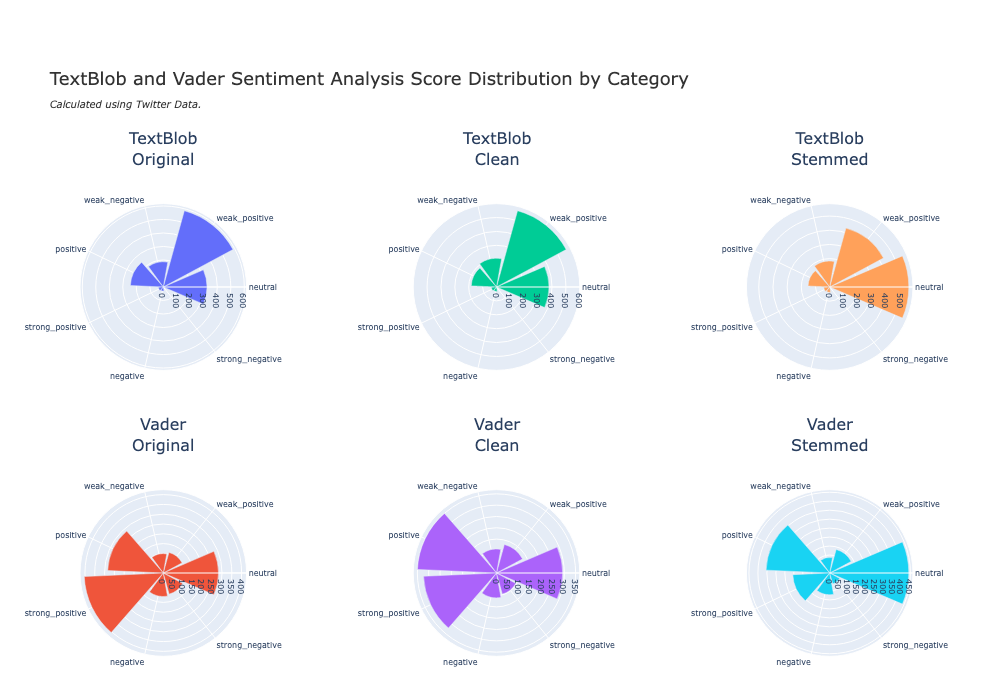

In [30]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

col = ['TextBlob_desc', 'Vader_desc', 'TextBlob_o_desc',
       'TextBlob_c_desc', 'Vader_c_desc', 'Vader_o_desc']

m = Count_Values(df = tweets,
                 columns = col)

title = f'TextBlob and Vader Sentiment Analysis Score Distribution by Category' \
        f'<br><span style="font-size:10px"><i>Calculated using Twitter Data.</span></i>'

fig = make_subplots(
    rows=2, cols=3,
    vertical_spacing=0.1,
    horizontal_spacing=0.2,
    specs=[[{"type": "barpolar"}, {"type": "barpolar"}, {"type": "barpolar"}],
          [{"type": "barpolar"}, {"type": "barpolar"}, {"type": "barpolar"}]],
    subplot_titles=("TextBlob<br>Original",
                    "TextBlob<br>Clean",
                    "TextBlob<br>Stemmed",
                   "Vader<br>Original", "Vader<br>Clean","Vader<br>Stemmed")

)

# Row 1 = TextBlob | Row 2 = Vader

#col 1 = Original
fig.add_trace(go.Barpolar(theta=m['values'], r=m['TextBlob_o_desc']),
              row=1, col=1)

fig.add_trace(go.Barpolar(theta=m['values'], r=m['Vader_o_desc']),
              row=2, col=1)


#col 2 = Clean
fig.add_trace(go.Barpolar(theta=m['values'], r=m['TextBlob_c_desc']),
              row=1, col=2)

fig.add_trace(go.Barpolar(theta=m['values'], r=m['Vader_c_desc']),
              row=2, col=2)

#col 3 = Stemmed
fig.add_trace(go.Barpolar(theta=m['values'], r=m['TextBlob_desc']),
              row=1, col=3)

fig.add_trace(go.Barpolar(theta=m['values'], r=m['Vader_desc']),
              row=2, col=3)


fig.update_layout(
    showlegend=False,
    font_size=8,
    title_font_size=18,
    title_text=title,
    title_font_color='#333333',
    width = 1200,
    height=700,
    plot_bgcolor='white',
    margin_t=170,
    margin_b=10)

fig.show()

Claramente há uma perda da intensidade na análises das ferramentas, classificando os textos de forma mais neutra após as fases de tratamento do texto, uma vez que estas ferramentas utilizam caracteres removidas para calcula a intensidade das emoções.

There is clearly a loss of intensity in the analysis of the tools, classifying texts more neutrally after the text treatment phases, since these tools use removed characters to calculate the intensity of emotions.

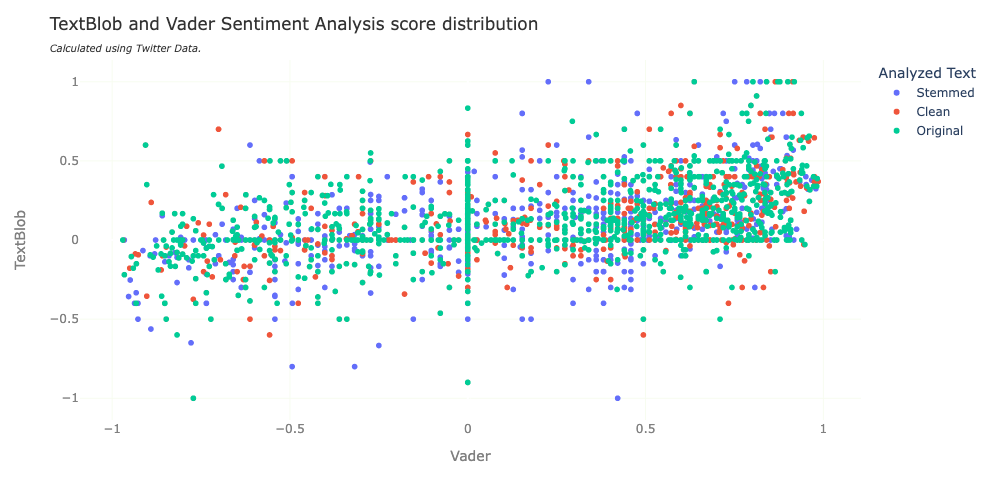

In [31]:

#Creating Df to plot
t = pd.melt(tweets.reset_index(), id_vars='index', value_vars=['TextBlob','TextBlob_c', 'TextBlob_o'])
v = pd.melt(tweets.reset_index(), id_vars='index', value_vars=['Vader_c','Vader','Vader_o'])

t = t.replace({'TextBlob' : 'Stemmed',
               'TextBlob_c' : 'Clean',
               'TextBlob_o' : 'Original'})
v = v.replace({'Vader' : 'Stemmed',
               'Vader_c' : 'Clean',
               'Vader_o' : 'Original'})

m = t.merge(v, how='inner', on=['index', 'variable'])
del t, v
m = m.drop('index', axis = 1).rename(columns={'value_x' : 'TextBlob', 'value_y':'Vader'})

m

title = f'TextBlob and Vader Sentiment Analysis score distribution' \
        f'<br><span style="font-size:10px"><i>Calculated using Twitter Data.</span></i>'

fig =px.scatter( y= m['TextBlob'], 
                x=m['Vader'],
               color = m['variable'])


fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    width = 1000,
    height=500,
    plot_bgcolor='white',
    #yaxis_visible=False,
    xaxis_title_font_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    xaxis_color='grey',
    yaxis_title_text = 'TextBlob',
    xaxis_title_text = 'Vader',
    yaxis_gridcolor = '#F7FCF0',
    xaxis_gridcolor = '#F7FCF0',
    #xaxis_showgrid=True, 
    coloraxis_showscale=False,
    legend_title_text= "Analyzed Text")

Neste gráfico é possível ver a alteração da dispersão dos pontos de acordo com o processo de tratamento, quanto mais tratado os dados mais eles se acumulmam nos eixos 0 (neutro).

In this graph it is possible to see the change in the dispersion of the points according to the treatment process, the more treated the data the more they accumulate in the 0 (neutral) axes.

## Sarcasm

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
news = pd.read_csv('sarcasm_headlines.bz2')
news.sample()

headline  is_sarcastic
24614  innovation steam awards given to 8 schools             0

In [34]:
print(news.isnull().any(axis = 0))

headline        False
is_sarcastic    False
dtype: bool


In [36]:
stemming(news, 'headline', 'headline_ps')

Stemmer done!


In [37]:
news.sample(2)

headline  is_sarcastic  \
8427  florida state university suspends greek life a...             0   
8244            cd club somehow tracks down local woman             1   

                                            headline_ps  
8427  florida state univers suspend greek life stude...  
8244                  cd club somehow track local woman

In [38]:
def create_features(df, col, max_feat):
    features = df[col]

    # vectorizing the data with maximum features
    tv = TfidfVectorizer(max_features = max_feat)
    features = list(features)
    features = tv.fit_transform(features).toarray()
    
    return features

TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction. Let’s take sample example and explore two different spicy sparse matrix before go into deep explanation 

In [39]:
features = create_features(news, 'headline_ps', 5000)
labels = news['is_sarcastic']

In [40]:
# getting training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.5, random_state = 0)

In [41]:
%%time
print('\nLinear Support Vector Classifier:')
lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)
print('Train: ',lsvc.score(features_train, labels_train))
print('Test: ',lsvc.score(features_test, labels_test))


print('\nGaussian Naive Bayes:')
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print('Train: ',gnb.score(features_train, labels_train))
print('Test: ',gnb.score(features_test, labels_test))


print('\nLogistic Regression:')
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print('Train: ',lr.score(features_train, labels_train))
print('Test: ',lr.score(features_test, labels_test))


print('\nRandom Forest Classifier:')
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print('Train: ',rfc.score(features_train, labels_train))
print('Test: ',rfc.score(features_test, labels_test))


Linear Support Vector Classifier:
Train:  0.9092406769507264
Test:  0.7648820666417072

Gaussian Naive Bayes:
Train:  0.7633667814886925
Test:  0.6566080119805316

Logistic Regression:
Train:  0.8530777295192452
Test:  0.7728940471733433

Random Forest Classifier:
Train:  0.9850980979481804
Test:  0.7307375514788469
CPU times: user 44 s, sys: 4.73 s, total: 48.8 s
Wall time: 50.6 s


### Cross-Validation

#### KFold

k-Fold cross-validation is a technique that minimizes the disadvantages of the hold-out method. k-Fold introduces a new way of splitting the dataset which helps to overcome the “test only once bottleneck”.

In [33]:
%%time
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

kf =KFold(n_splits=5, shuffle=True, random_state=42)


print('\nLinear Support Vector Classifier:')
score = cross_val_score(lsvc, features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')


Linear Support Vector Classifier:
Scores for each fold are: [0.77592662 0.79146387 0.77143392 0.78491202 0.77682082]
Average score: 0.78
CPU times: user 7.19 s, sys: 3.88 s, total: 11.1 s
Wall time: 11.1 s


In [34]:
%%time
print('\nGaussuan Naive Bayes:')
score = cross_val_score(gnb, features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')



Gaussuan Naive Bayes:
Scores for each fold are: [0.68962935 0.68831898 0.66847623 0.68775739 0.68807339]
Average score: 0.68
CPU times: user 14.1 s, sys: 12.7 s, total: 26.7 s
Wall time: 30.3 s


In [35]:
%%time

print('\nLogistic Regression:')
score = cross_val_score(lr, features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')



Logistic Regression:
Scores for each fold are: [0.785848   0.79801572 0.77873456 0.78172969 0.77925482]
Average score: 0.78
CPU times: user 1min 51s, sys: 3.36 s, total: 1min 54s
Wall time: 1min 3s


In [36]:
%%time

print('\nRandom Forest Classifier:')
score = cross_val_score(rfc, features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')


Random Forest Classifier:
Scores for each fold are: [0.74653688 0.74728566 0.73867465 0.73567952 0.73993634]
Average score: 0.74
CPU times: user 4min 40s, sys: 7.71 s, total: 4min 48s
Wall time: 4min 59s


### Learning Curve

Determines cross-validated training and test scores for different training set sizes.

In [37]:
def get_learning_curve(model, X, y, cv, model_name):
    print(f'Getting Learning Curve for {model_name}')
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X, 
                                                            y, 
                                                            cv=cv, 
                                                            scoring='accuracy',
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(0.01, 1.0, 10))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    print('Training Score:')
    print(f'Average: {"{:.2f}".format(train_scores.mean())}')
    print(f'Standard Deviation: {"{:.2f}".format(train_scores.std())}')

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    print('\nTest Score:')
    print(f'Average: {"{:.2f}".format(test_scores.mean())}')
    print(f'Standard Deviation: {"{:.2f}".format(test_scores.std())}')
    
    print('\n')
    
    plt.subplots(1, figsize=(7,5))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

Getting Learning Curve for Linear Support Vector Classifier
Training Score:
Average: 0.93
Standard Deviation: 0.04

Test Score:
Average: 0.74
Standard Deviation: 0.05




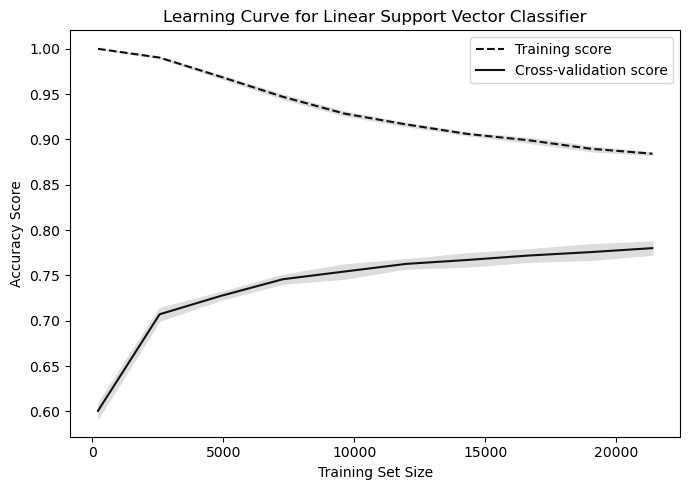

CPU times: user 810 ms, sys: 1.29 s, total: 2.1 s
Wall time: 1min 1s


In [38]:
%%time
get_learning_curve(model = lsvc,
               X = features,
               y = labels,
               cv = kf,
               model_name = 'Linear Support Vector Classifier')

Getting Learning Curve for Logistic Regression
Training Score:
Average: 0.87
Standard Deviation: 0.03

Test Score:
Average: 0.74
Standard Deviation: 0.06




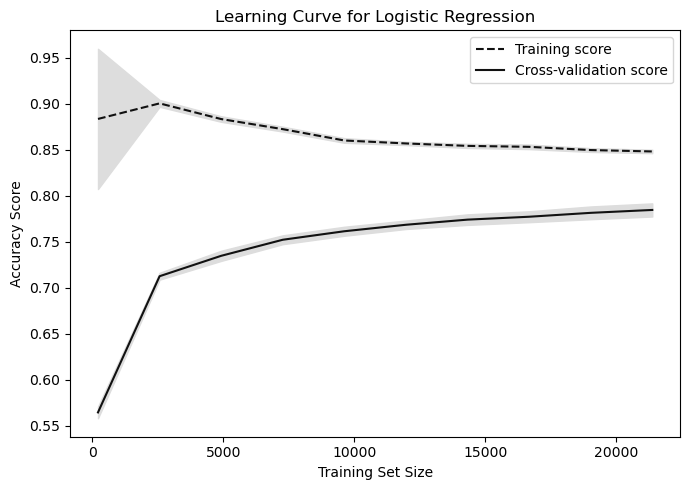

CPU times: user 1.11 s, sys: 1.74 s, total: 2.84 s
Wall time: 6min 7s


In [39]:
%%time
get_learning_curve(model = lr,
               X = features,
               y = labels,
               cv = kf,
               model_name = 'Logistic Regression')

Getting Learning Curve for Gaussuan Naive Bayes
Training Score:
Average: 0.81
Standard Deviation: 0.07

Test Score:
Average: 0.63
Standard Deviation: 0.04




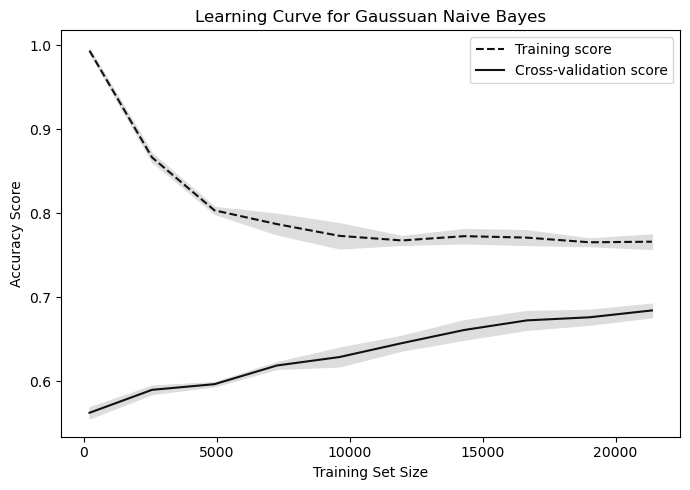

CPU times: user 1.04 s, sys: 2.34 s, total: 3.38 s
Wall time: 7min 40s


In [40]:
%%time
get_learning_curve(model = gnb,
               X = features,
               y = labels,
               cv = kf,
               model_name = 'Gaussuan Naive Bayes')

### Prev

In [42]:
prev = create_features(tweets, 'text_ps', 5000)

In [43]:
tweets['is_sarcastic_lsvc'] = lsvc.predict(prev)

In [44]:
tweets['is_sarcastic_lr'] = lr.predict(prev)

In [45]:
tweets.sample(4)

public_metrics      conversation_id  \
787  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1606240784835125248   
579  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1610426951667453953   
639  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1609960136574992390   
916  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1604896440463069209   

                                                  text reply_settings lang  \
787  # Russian state group has kept sufficient deli...       everyone   en   
579  The Oxford Real Farming Conference, in-person ...       everyone   en   
639  CHANGE THE LAW. PROTECT THE INNOCENT. https://...       everyone   en   
916  @WallStreetSilv Ireland, biggest income genera...       everyone   en   

               author_id   edit_history_tweet_ids                created_at  \
787  1600154485577650176  ['1606240784835125248']  2022-12-23T10:50:20.000Z   
579           2172917191  ['1610426951667453953']  2023-01-04T00:04:40.000Z   
639  1438893702504755202  ['1609960136574992390']  2023-01-02T17:09:42.000Z   
916  1293214608254275586  ['1604910799696396293']  2022-12-19T18:45:27.000Z   

               id  in_reply_to_user_id  ... TextBlob_o Vader_o  TextBlob_desc  \
787           NaN                  NaN  ...        0.0  0.5267        neutral   
579  1.610427e+18                  NaN  ...        0.2  0.0000  weak_positive   
639  1.609960e+18                  NaN  ...        0.5  0.7555        neutral   
916           NaN         1.366566e+18  ...        0.0  0.0000        neutral   

    TextBlob_o_desc TextBlob_c_desc Vader_desc     Vader_o_desc  \
787         neutral         neutral   positive         positive   
579   weak_positive   weak_positive    neutral          neutral   
639        positive        positive   positive  strong_positive   
916         neutral         neutral    neutral          neutral   

        Vader_c_desc  is_sarcastic_lsvc  is_sarcastic_lr  
787  strong_positive                  0                0  
579          neutral                  1                1  
639  strong_positive                  0                0  
916          neutral                  0                0  

[4 rows x 30 columns]

In [46]:
##Checking Twitters
def Check_tweet(n):
    print('Text Original:\n', tweets.loc[n, 'text'], '\n',
         '-------------------------------------------------------------------------------------------')
    print('Text Clear:\n', tweets.loc[n, 'text_c'], '\n',
         '-------------------------------------------------------------------------------------------')

    print('Text Steammed:\n', tweets.loc[n, 'text_ps'], '\n',
         '-------------------------------------------------------------------------------------------')

    print('KeyWords:\n', tweets.loc[n, 'keywords'], '\n',
         '-------------------------------------------------------------------------------------------')

    print('\nCountry: ', tweets.loc[n, 'country'])

    print('\nTextBlob')
    print('Original: ',f"{tweets.loc[n, 'TextBlob_o']:,.3f}", tweets.loc[n, 'TextBlob_o_desc'])
    print('Clean: ',f"{tweets.loc[n, 'TextBlob_c']:,.3f}", tweets.loc[n, 'TextBlob_c_desc'])
    print('Stemmed: ',f"{tweets.loc[n, 'TextBlob']:,.3f}", tweets.loc[n, 'TextBlob_desc'])

    print('\nVader')
    print('Original: ', f"{tweets.loc[n, 'Vader_o']:,.3f}", tweets.loc[n, 'Vader_o_desc'])
    print('Clean: ', f"{tweets.loc[n, 'Vader_c']:,.3f}", tweets.loc[n, 'Vader_c_desc'])
    print('Stemmed: ', f"{tweets.loc[n, 'Vader']:,.3f}", tweets.loc[n, 'Vader_desc'])

    print('\nSarcasm')
    print('LSVC: ', tweets.loc[n, 'is_sarcastic_lsvc'])
    print('LR: ', tweets.loc[n, 'is_sarcastic_lr'])


In [47]:
Check_tweet(300)

Text Original:
 A warm welcome to Sweden taking the EU Council Presidency today 🇪🇺🇸🇪.
I look forward to a constructive and successful cooperation in matters related to agriculture. #EU2023SE

Thank you 🇨🇿 Czech Council presidency @EU2022_CZ for your excellent work! #EU2022CZ https://t.co/d1Fpkaugo9 
 -------------------------------------------------------------------------------------------
Text Clear:
 A warm welcome to Sweden taking EU Council Presidency I look forward to a constructive successful cooperation in matters related to EU2023SE Thank you Czech Council presidency for your excellent work EU2022CZ 
 -------------------------------------------------------------------------------------------
Text Steammed:
 warm welcom sweden take eu council presid look forward construct success cooper matter relat eu se thank czech council presid excel work eu cz 
 -------------------------------------------------------------------------------------------
KeyWords:
 ['#EU2023SE', '#EU2022CZ']

In [76]:
t = tweets.copy()

t['is_sarcasm'] = t[['is_sarcastic_lsvc', 'is_sarcastic_lr']].sum(axis=1)
t = t['is_sarcasm'].replace({0: 'Not', 1: 'Diverge', 2:'Yes'})
tweets = pd.concat([tweets, t], axis = 1)
del t
tweets.sample(5)

public_metrics      conversation_id  \
105  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1608744227785134081   
888  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1606287339801681920   
641  {'retweet_count': 0, 'reply_count': 1, 'like_c...  1609933043183063042   
153  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1610665532780421120   
115  {'retweet_count': 0, 'reply_count': 0, 'like_c...  1327153503958147073   

                                                  text reply_settings lang  \
105  Germany’s first regen ag ‘Farmer of the Year’ ...       everyone   en   
888  Assistant Secretary (Head of Seafood and Marin...       everyone   en   
641  “A great deal is something more beneficial to ...       everyone   en   
153  Ben See.@climateben\n\n"Intensive agriculture ...       everyone   en   
115  @thisisGBA Cpec rpec projects 🌊💦 electric gas ...       everyone   en   

               author_id   edit_history_tweet_ids                created_at  \
105  1316033791618510850  ['1608744227785134081']  2022-12-30T08:38:07.000Z   
888             63684604  ['1606287339801681920']  2022-12-23T13:55:19.000Z   
641  1097460462260760576  ['1609933043183063042']  2023-01-02T15:22:03.000Z   
153  1189877149987229696  ['1610665532780421120']  2023-01-04T15:52:42.000Z   
115  1566407156576002050  ['1609902899512971264']  2023-01-02T13:22:16.000Z   

               id  in_reply_to_user_id  ... Vader_o  TextBlob_desc  \
105  1.608744e+18                  NaN  ...  0.0000  weak_positive   
888           NaN                  NaN  ...  0.0000        neutral   
641  1.609933e+18                  NaN  ...  0.8399       positive   
153  1.610666e+18                  NaN  ...  0.5106  weak_positive   
115  1.609903e+18         1.290912e+18  ...  0.8910  weak_positive   

    TextBlob_o_desc TextBlob_c_desc       Vader_desc     Vader_o_desc  \
105        positive   weak_positive    weak_positive          neutral   
888         neutral         neutral          neutral          neutral   
641        positive        positive  strong_positive  strong_positive   
153   weak_positive   weak_positive         positive         positive   
115   weak_positive   weak_positive         positive  strong_positive   

        Vader_c_desc  is_sarcastic_lsvc  is_sarcastic_lr  is_sarcasm  
105          neutral                  0                0         Not  
888          neutral                  1                0     Diverge  
641  strong_positive                  0                0         Not  
153         positive                  0                0         Not  
115         positive                  1                1         Yes  

[5 rows x 31 columns]

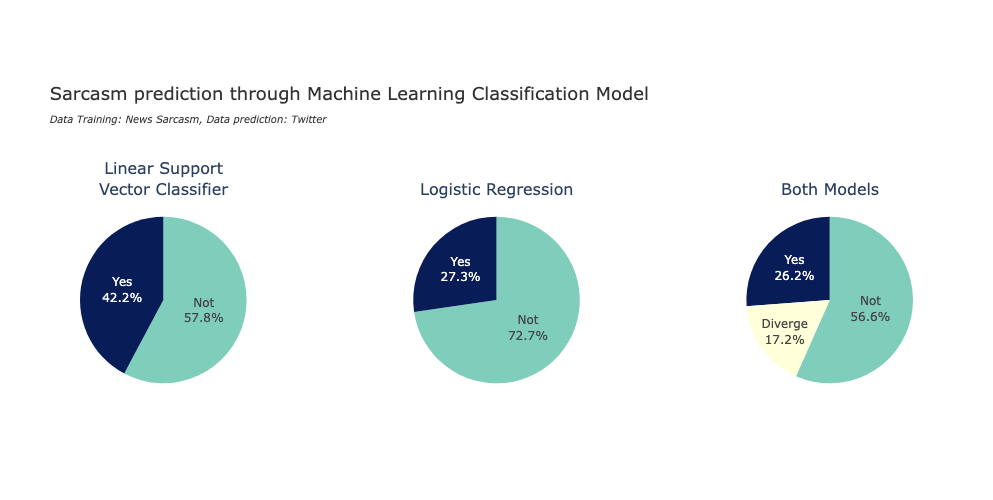

In [120]:
title = f'Sarcasm prediction through Machine Learning Classification Model' \
        f'<br><span style="font-size:10px"><i>Data Training: News Sarcasm, Data prediction: Twitter</span></i>'

fig = make_subplots(
    rows=1, cols=3,
    vertical_spacing=0.1,
    horizontal_spacing=0.2,
    specs=[[{"type": "domain"}, {"type": "domain"}, {"type": "domain"}]],
    subplot_titles=("Linear Support<br>Vector Classifier",
                    "Logistic Regression",
                   "Both Models")

)

fig.add_trace(go.Pie(values=tweets['is_sarcastic_lsvc'].value_counts().values,
                    text =['Not','Yes']),
              row=1, col=1)

fig.add_trace(go.Pie(values=tweets['is_sarcastic_lr'].value_counts().values,
                     text = ['Not','Yes']),
              row=1, col=2)

fig.add_trace(go.Pie(values=tweets['is_sarcasm'].value_counts().values,
                     text = tweets['is_sarcasm'].value_counts().index),
              row=1, col=3)


fig.update_layout(
    showlegend=False,
    font_size=12,
    title_font_size=18,
    title_text=title,
    title_font_color='#333333',
    width = 1000,
    height=500,
    plot_bgcolor='white',
    margin_t=200,
    margin_b=100)

fig.update_traces(marker=dict(colors=['#7fcdbb', '#081d58', "#ffffd9"]))

fig.show()

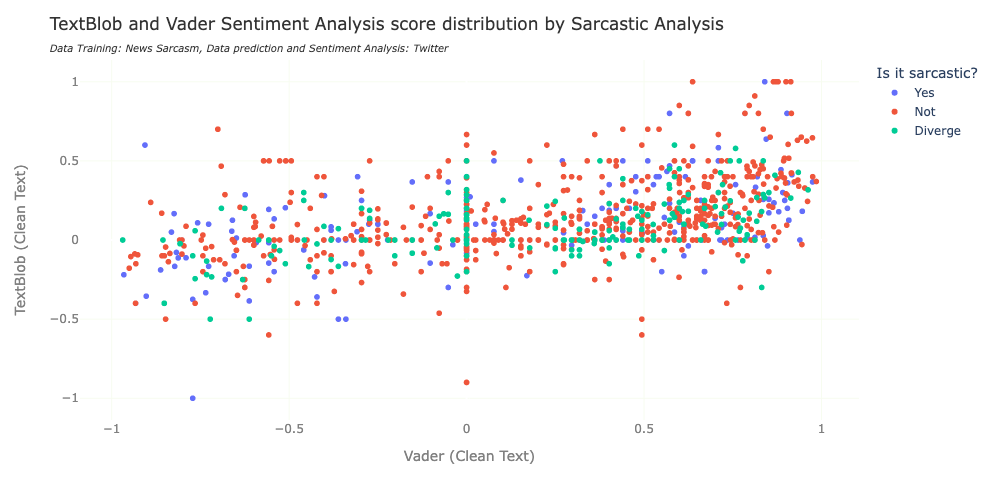

In [125]:
#Creating Df to plot
m = tweets

title = f'TextBlob and Vader Sentiment Analysis score distribution by Sarcastic Analysis' \
        f'<br><span style="font-size:10px"><i>Data Training: News Sarcasm, Data prediction and Sentiment Analysis: Twitter</span></i>'

fig =px.scatter( y= m['TextBlob_c'], 
                x=m['Vader_c'],
               color = m['is_sarcasm'])


fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    width = 1000,
    height=500,
    plot_bgcolor='white',
    #yaxis_visible=False,
    xaxis_title_font_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    xaxis_color='grey',
    yaxis_title_text = 'TextBlob (Clean Text)',
    xaxis_title_text = 'Vader (Clean Text)',
    yaxis_gridcolor = '#F7FCF0',
    xaxis_gridcolor = '#F7FCF0',
    #xaxis_showgrid=True, 
    coloraxis_showscale=False,
    legend_title_text= "Is it sarcastic?")

#### Disagree

In [60]:
#Because the random collection of the condition below needs to be reproduced, the indexes are entered manually
#check = tweets[tweets['is_sarcasm'] == 'Diverge'].sample(10).index

check = [326, 1113, 1149, 1009, 986, 1166, 250, 877, 567, 994]
for c in check:
    Check_tweet(c)
    print('\n************************************************************************************************************\n')

Text Original:
 @ThePollLady If we protect environment, rest with take care of itself.
Agriculture +Animal Husbandry are Foundation of civilization. I doubt intentions of those who say farming +animal farts cause dangerous climate change.
Needs serious debunking, yet Europe willing to cull cows! 
 -------------------------------------------------------------------------------------------
Text Clear:
 we protect rest with take care of itself Animal Husbandry Foundation of civilization I doubt intentions of those who say animal farts cause dangerous climate Needs serious debunking yet willing to cull cows 
 -------------------------------------------------------------------------------------------
Text Steammed:
 protect rest take care anim husbandri foundat civil doubt intent say anim fart caus danger climat need seriou debunk yet will cull cow 
 -------------------------------------------------------------------------------------------
KeyWords:
 [] 
 ----------------------------------

#### Agree

##### Both positive

In [62]:
#Because the random collection of the condition below needs to be reproduced, the indexes are entered manually
#check = tweets[tweets['is_sarcasm'] == 'Yes'].sample(10).index

check = [302, 1032, 1393, 1361, 1203, 263, 776, 1028, 608, 1392]
for c in check:
    Check_tweet(c)
    print('\n************************************************************************************************************\n')

Text Original:
 @consoleghana @RAahiagbah @MBawumia @NPP_GH 
Our Prez Nana Addo and Vice Bawumia would PREFER investing heavily on Cathedral, Large Size Gov't &amp; Lavish convoys instead of agriculture, the youth, education and sports.
Ghana has more church buildings than the entire Europe. But gov't... 
 -------------------------------------------------------------------------------------------
Text Clear:
 Our Prez Nana Addo Vice Bawumia would PREFER investing heavily on Cathedral Large Size Gov amp Lavish convoys instead of youth sports Ghana has church buildings than entire But gov 
 -------------------------------------------------------------------------------------------
Text Steammed:
 prez nana addo vice bawumia would prefer invest heavili cathedr larg size gov amp lavish convoy instead youth sport ghana church build entir gov 
 -------------------------------------------------------------------------------------------
KeyWords:
 [] 
 -----------------------------------------

##### Both Negative

In [136]:
#Because the random collection of the condition below needs to be reproduced, the indexes are entered manually
#check = tweets[tweets['is_sarcasm'] == 'Not'].sample(10).index

check = [329, 1189, 392, 303, 995, 663, 1281, 632, 247, 408]
for c in check:
    Check_tweet(c)
    print('\n************************************************************************************************************\n')

Text Original:
 @CoftonDan @ThierryAaron Geologically, the Earth was much different than it is today; much colder at times, and much warmer at times.  The very future of Europe can be unlocked within the layers of geology.  Desert conditions are not the end; agriculture can be moved indoors, for example. 
 -------------------------------------------------------------------------------------------
Text Clear:
 Geologically Earth was much different than it is much colder at times much warmer at times very future of can be unlocked within layers of geology Desert conditions not end can be moved indoors for example 
 -------------------------------------------------------------------------------------------
Text Steammed:
 geolog earth much differ much colder time much warmer time futur unlock within layer geolog desert condit end move indoor exampl 
 -------------------------------------------------------------------------------------------
KeyWords:
 [] 
 --------------------------------

# Word Cloud

In [129]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [127]:
def Plot_WordCloud(data, column_words, drop_word = [], min_df = .01, max_df = .6, figsize=[12,8]):

    vectorizer = TfidfVectorizer(stop_words='english', min_df = min_df, max_df = max_df) #ngram_range = (1,1)
    X = vectorizer.fit_transform(data[column_words])
    feature_names = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)


    #removing words
    
    for d in drop_word:
        try:
            df = df.drop(d , axis = 1)
        except:
            pass

    df = df.T
    df['total'] = df.sum(axis=1)

    print(f'Total of words: {len(df)}')

    wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', 
                          background_color="white", 
                          width=3000, 
                          height=2000, 
                          max_words=500
                         ).generate_from_frequencies(df['total'])

    plt.figure(figsize=[12,8])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off");

## All Sentiment

Total of words: 259


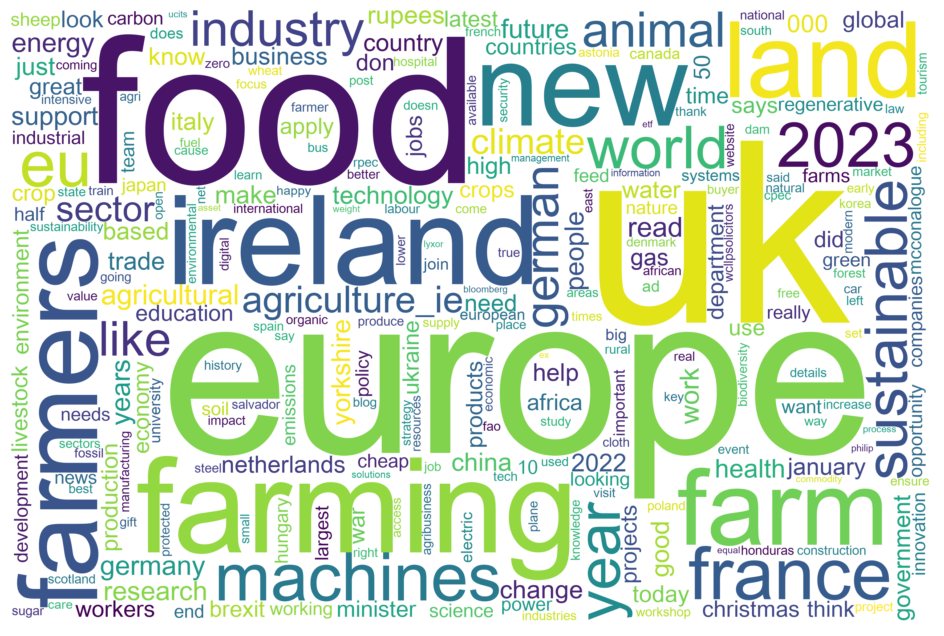

In [416]:
Plot_WordCloud(data = tweets,
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])

## Negative Sentiment

Total of words: 339


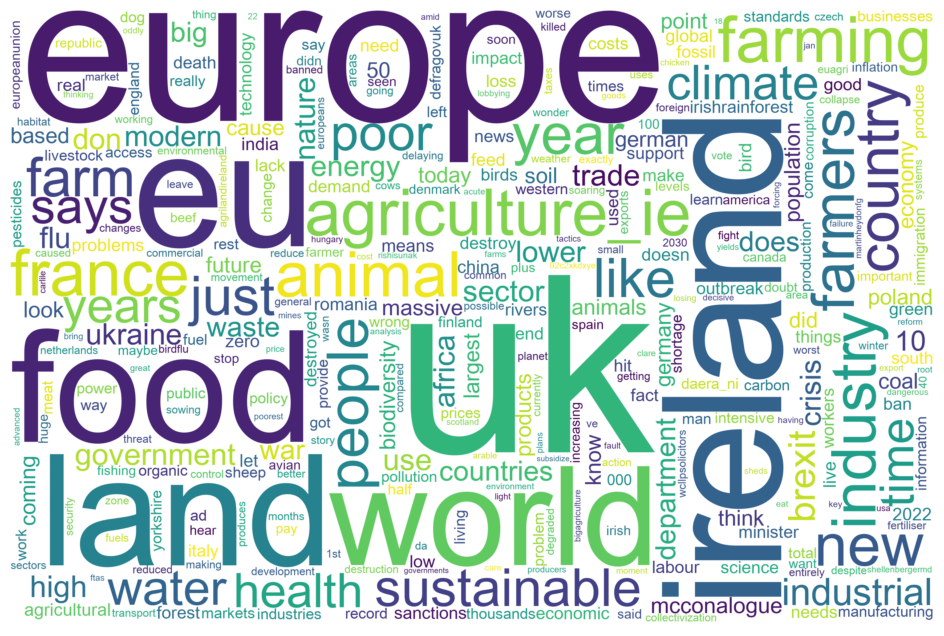

In [130]:
neg_sent = ['weak_negative','negative','strong_negative']

Plot_WordCloud(data = tweets[tweets['Vader_c_desc'].isin(neg_sent)],
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])

## Positive Sentiment

Total of words: 265


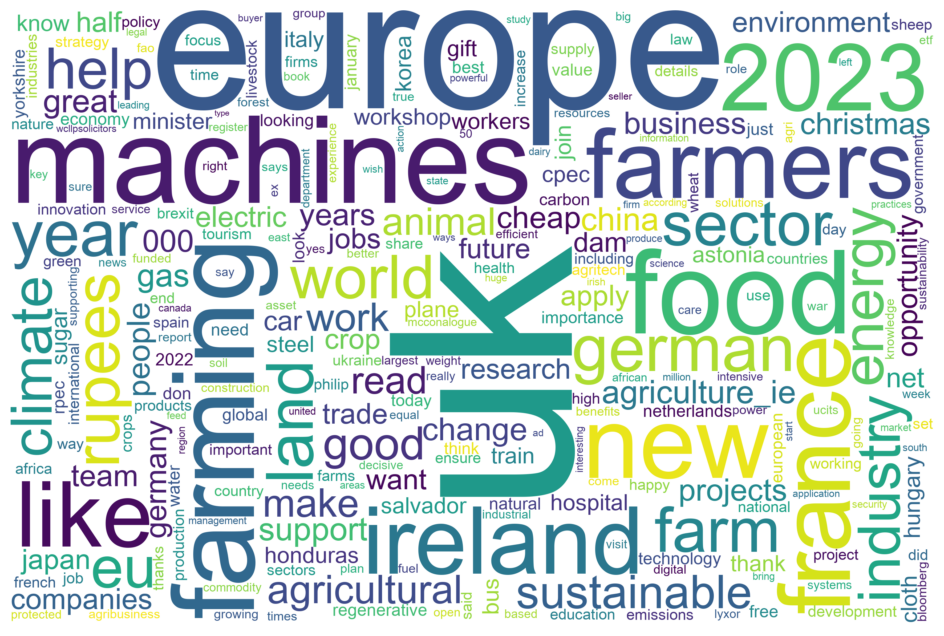

In [134]:
pos_sent = ['strong_positive','positive','weak_positive']
Plot_WordCloud(data = tweets[tweets['Vader_c_desc'].isin(pos_sent)],
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])

## Neutral Sentiment

Total of words: 315


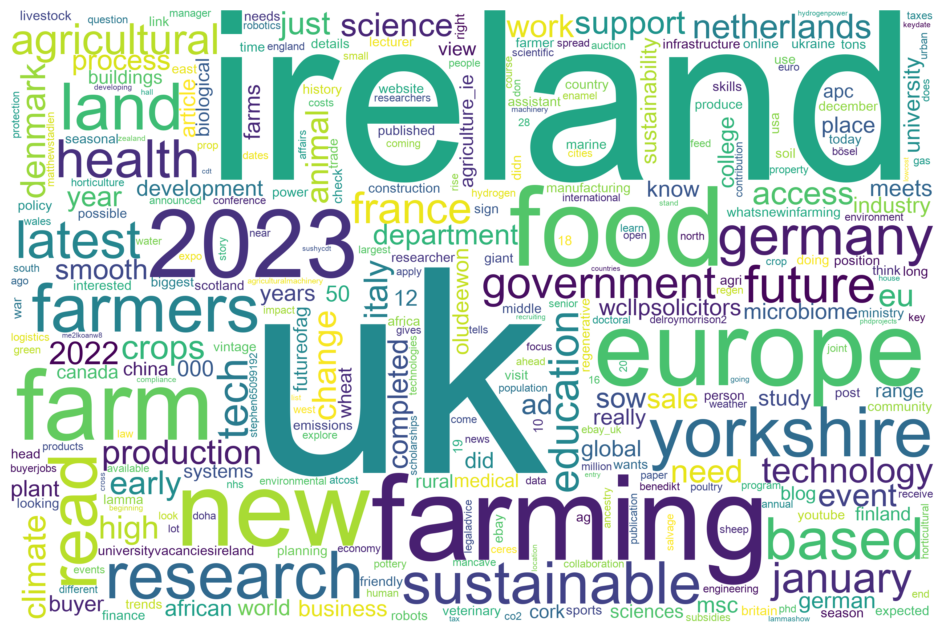

In [133]:
neu_sent = ['neutral']

Plot_WordCloud(data = tweets[tweets['Vader_c_desc'].isin(neu_sent)],
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])